# Recommendation engine
This notebook is inspired by the following articles:
- __Comprehensive Guide to build a Recommendation Engine from scratch (in Python)__  
https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-recommendation-engine-python/
- __Implementing your own recommender systems in Python__   
https://cambridgespark.com/content/tutorials/implementing-your-own-recommender-systems-in-Python/index.html

The goal is to get the hands on implementing a recommendation engine and understand their strenght, limitations and other subtilties.  
The following is to be considered as a summary of this article.

## Introduction
A recommendation engine filters the data using different algorithms and recommends the most relevant items to users. It first captures the past behavior of a customer and based on that, recommends products which the users might be likely to buy.

There are several ways to recommend items to users:
- We can recommend items to a user which are most popular among all the users
- We can divide the users into multiple segments based on their preferences (user features) and recommend items to them based on the segment they belong to

Both of the above methods have their drawbacks. In the first case, the most popular items would be the same for each user so everybody will see the same recommendations. While in the second case, as the number of users increases, the number of features will also increase. So classifying the users into various segments will be a very difficult task.

Let's explore each type of recommendation

## Content based filtering
This algorithm recommends products which are similar to the ones that a user has liked in the past.
Consider the example of Netflix. They save all the information related to each user in a vector form. This vector contains the past behavior of the user, i.e. the movies liked/disliked by the user and the ratings given by them. This vector is known as the profile vector. All the information related to movies is stored in another vector called the item vector. Item vector contains the details of each movie, like genre, cast, director, etc.

The content-based filtering algorithm finds the cosine of the angle between the profile vector and item vector, i.e. cosine similarity. Suppose A is the profile vector and B is the item vector, then the similarity between them can be calculated as:

$$sim(A,B) = cos(\theta) = \frac{A.B}{||A||.||B||}$$

Based on the cosine value, which ranges between -1 to 1, the movies are arranged in descending order and one of the two below approaches is used for recommendations:

- Top-n approach: where the top n movies are recommended (Here n can be decided by the business)
- Rating scale approach: Where a threshold is set and all the movies above that threshold are recommended

Other methods that can be used to calculate the similarity are:
- Euclidean Distance
- Pearson’s Correlation

A major drawback of this algorithm is that it is limited to recommending items that are of the same type. It will never recommend products which the user has not bought or liked in the past. So if a user has watched or liked only action movies in the past, the system will recommend only action movies. It’s a very narrow way of building an engine.

To improve on this type of system, we need an algorithm that can recommend items not just based on the content, but the behavior of users as well.


## Collaborative filtering
The collaborative filtering algorithm uses “User Behavior” for recommending items. This is one of the most commonly used algorithms in the industry as it is not dependent on any additional information. There are different types of collaborating filtering techniques and we shall look at them in detail below.

### User-User collaborative filtering
This algorithm first finds the similarity score between users. Based on this similarity score, it then picks out the most similar users and recommends products which these similar users have liked or bought previously.  
In terms of our movies example from earlier, this algorithm finds the similarity between each user based on the ratings they have previously given to different movies. The prediction of an item for a user u is calculated by computing the weighted sum of the user ratings given by other users to an item i.

$$P_{u,i} = \frac{\sum_v r_{v,i}  s_{u,v}}{\sum_v s_{u,v}}$$

Here,

- $P_{u,i}$ is the prediction of an item
- $r_{v,i}$ is the rating given by a user v to a movie i
- $s_{u,v}$ is the similarity between users (Pearson correlation)

Following steps are followed to do so:

1. For predictions we need the similarity between the user u and v. We can make use of Pearson correlation.
1. First we find the items rated by both the users and based on the ratings, correlation between the users is calculated.
1. The predictions can be calculated using the similarity values. This algorithm, first of all calculates the similarity between each user and then based on each similarity calculates the predictions. Users having higher correlation will tend to be similar.
1. Based on these prediction values, recommendations are made. Let us understand it with an example:

### Item-Item collaborative filtering
In this algorithm, we compute the similarity between each pair of items.
We will find the similarity between each movie pair and based on that, we will recommend similar movies which are liked by the users in the past. This algorithm works similar to user-user collaborative filtering with just a little change – instead of taking the weighted sum of ratings of “user-neighbors”, we take the weighted sum of ratings of “item-neighbors”. The prediction is given by:

$$P_{u,i} = \frac{\sum_N s_{i,N} r_{u,N}}{\sum_N |s_{i,N}|}$$

with $s_{i,j} = cos(\vec i,\vec j) = \frac{\vec i . \vec j}{||\vec i||||\vec j||}$

### Side note on cold start
Before going further and implementing these concepts, there is a question which we must know the answer to – what will happen if a new user or a new item is added in the dataset? It is called a Cold Start. There can be two types of cold start:

- Visitor Cold Start
- Product Cold Start

Visitor Cold Start means that a new user is introduced in the dataset. Since there is no history of that user, the system does not know the preferences of that user. It becomes harder to recommend products to that user. So, how can we solve this problem? One basic approach could be to apply a popularity based strategy, i.e. recommend the most popular products. These can be determined by what has been popular recently overall or regionally. Once we know the preferences of the user, recommending products will be easier.

On the other hand, Product Cold Start means that a new product is launched in the market or added to the system. User action is most important to determine the value of any product. More the interaction a product receives, the easier it is for our model to recommend that product to the right user. We can make use of Content based filtering to solve this problem. The system first uses the content of the new product for recommendations and then eventually the user actions on that product.

# Implementation 

We will download the MovieLens dataset (http://grouplens.org/datasets/movielens/100k/). We focus only on a subpart of the whole MovieLensdataset (100,000 ratings from 1000 users on 1700 movies).

Documentation about the dataset can be found here: http://files.grouplens.org/datasets/movielens/ml-100k-README.txt

## Loading the data

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

pd.options.display.max_columns = 50

In [2]:
#Reading users file:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols, encoding='latin-1')

#Reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols, encoding='latin-1')

#Reading items file:
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('ml-100k/u.item', sep='|', names=i_cols, encoding='latin-1')


In [3]:
print(users.shape)
users.head()

(943, 5)


user_id  age sex  occupation zip_code
0        1   24   M  technician    85711
1        2   53   F       other    94043
2        3   23   M      writer    32067
3        4   24   M  technician    43537
4        5   33   F       other    15213

In [4]:
print(ratings.shape)
ratings.head()

(100000, 4)


user_id  movie_id  rating  unix_timestamp
0      196       242       3       881250949
1      186       302       3       891717742
2       22       377       1       878887116
3      244        51       2       880606923
4      166       346       1       886397596

In [5]:
print(items.shape)
items.head()

(1682, 24)


movie id        movie title release date  video release date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995                 NaN   

                                            IMDb URL  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0       0   

   Adventure  Animation  Children's  Comedy  Crime  Documentary  Drama  \
0          0          1           1       1      0            0      0   
1          1          0           0       0      0            0      0   
2          0          0           0       0      0            0      0   
3          0          0           0       1      0            0      1   
4          0          0           0       0      1            0      1   

   Fantasy  Film-Noir  Horror  Musical  Mystery  Romance  Sci-Fi  Thriller  \
0        0          0       0        0        0        0       0         0   
1        0          0       0        0        0        0       0         1   
2        0          0       0        0        0        0       0         1   
3        0          0       0        0        0        0       0         0   
4        0          0       0        0        0        0       0         1   

   War  Western  
0    0        0  
1    0        0  
2    0        0  
3    0        0  
4    0        0

## Exploring movie ratings data

### Movies ratings

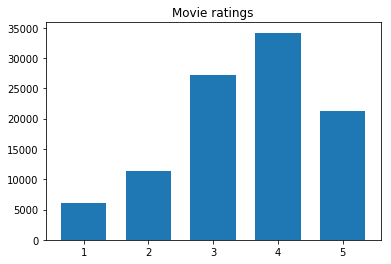

In [6]:
plt.figure()
plt.title("Movie ratings")
plt.hist(ratings["rating"]-0.5, bins=5, range=(0.5,5.5), rwidth=0.7)
plt.show()

### Number of times movies being rated

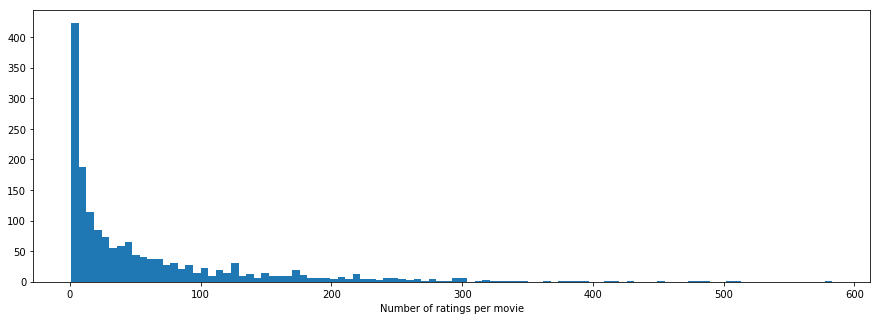

In [7]:
nr = ratings.groupby("movie_id")["rating"].size()
plt.figure(figsize=(15,5))
plt.hist(nr, bins=100)#, log=True)
plt.xlabel("Number of ratings per movie")
plt.show()

### Number of reviews vs mean movie ratings

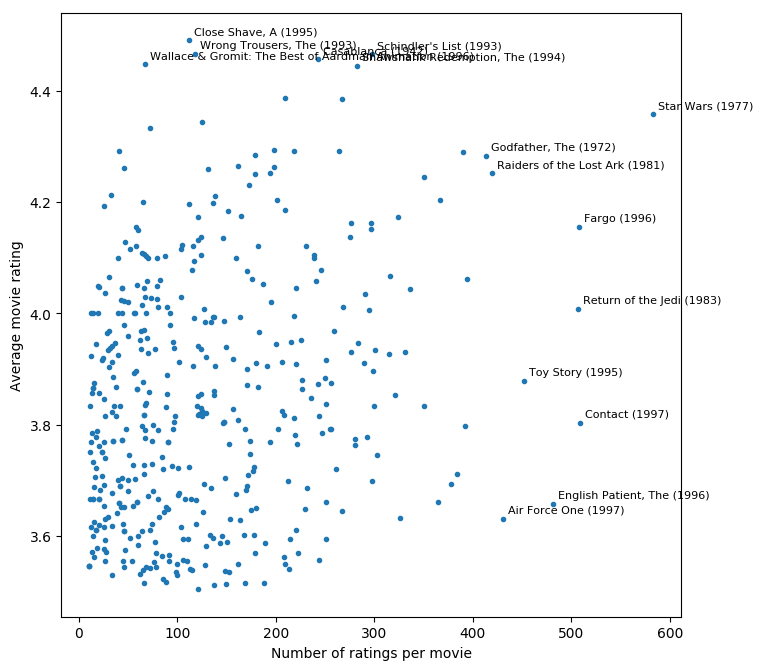

In [8]:
n_m_ratings = ratings.groupby("movie_id")["rating"].agg(["size","mean"])
n_m_ratings = n_m_ratings[(n_m_ratings["size"] > 10) & 
                          (n_m_ratings["mean"] > 3.5)]

plt.figure(figsize=(8,8), dpi=100)
plt.plot(n_m_ratings["size"], n_m_ratings["mean"], ".")
for i,d in n_m_ratings.iterrows():
    if (d["size"] > 400):
        plt.text(d["size"]+5,
                 d["mean"]+0.01,
                 items[items["movie id"]==i]["movie title"].values[0], 
                 fontsize=8)
        continue
    if (d["mean"] > 4.4):
        plt.text(d["size"]+5,
                 d["mean"]+0.01,
                 items[items["movie id"]==i]["movie title"].values[0], 
                 fontsize=8)

plt.xlabel("Number of ratings per movie")
plt.ylabel("Average movie rating")
plt.show()

### Age of reviewers

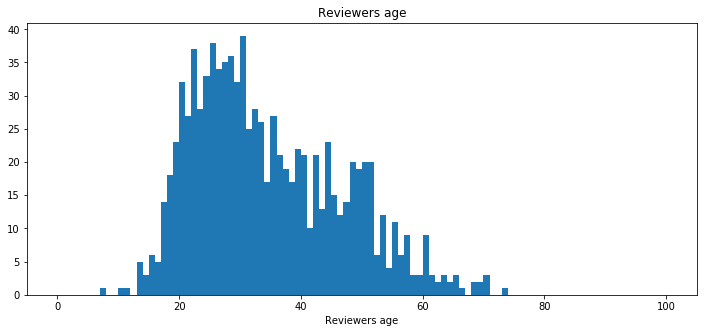

In [9]:
plt.figure(figsize=(12,5))
plt.title("Reviewers age")
plt.hist(users.age, bins=100, range=(0,100))
plt.xlabel("Reviewers age")
plt.show()

### Release date of movies

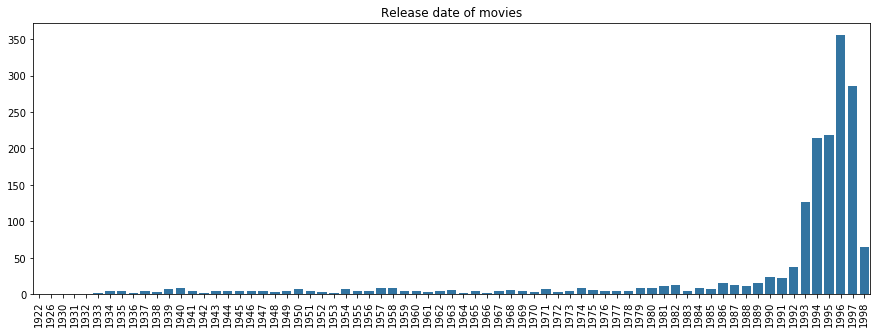

In [10]:
items["release date"] = pd.to_datetime(items["release date"])

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure(figsize=(15,5))
plt.title("Release date of movies")
sns.barplot(x=sorted(items["release date"].dt.year.dropna().apply(int).unique()), 
            y=items.groupby(items["release date"].dt.year).size(),
            color=colors[0]
           )
plt.xticks(rotation=90)
plt.show()

### Most rated movies

In [11]:
ratings_items = pd.merge(ratings, items, left_on="movie_id", right_on="movie id")
most_rated_movies = ratings_items.groupby("movie title").size().sort_values(ascending=False)

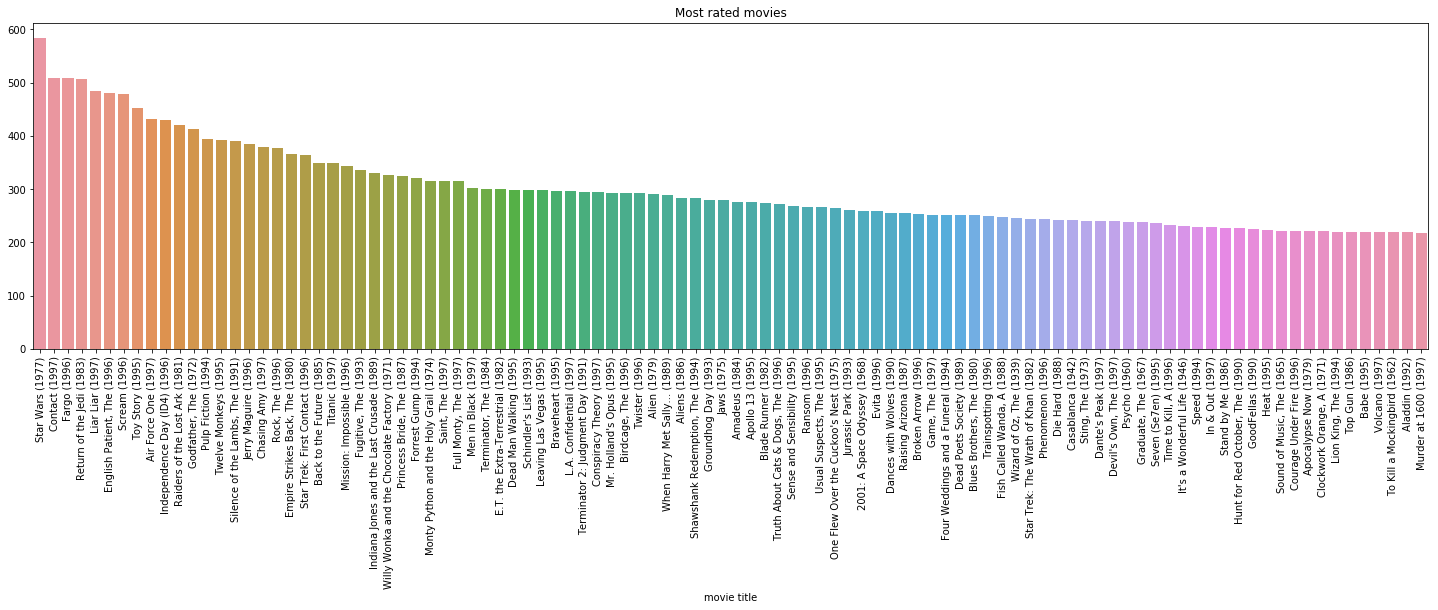

In [12]:
plt.figure(figsize=(25,6))
plt.title("Most rated movies")
sns.barplot(x=most_rated_movies.index[:100], y=most_rated_movies.values[:100])
plt.xticks(rotation=90)
plt.show()

### Best rated movie
Movie with at least 20 reviews are considered to avoid unknown movies.

In [13]:
mean_rating_movies = ratings_items.groupby("movie title").agg(["mean","size"])["rating"]
best_rated_movies = mean_rating_movies[mean_rating_movies["size"]>20].sort_values("mean",ascending=False)

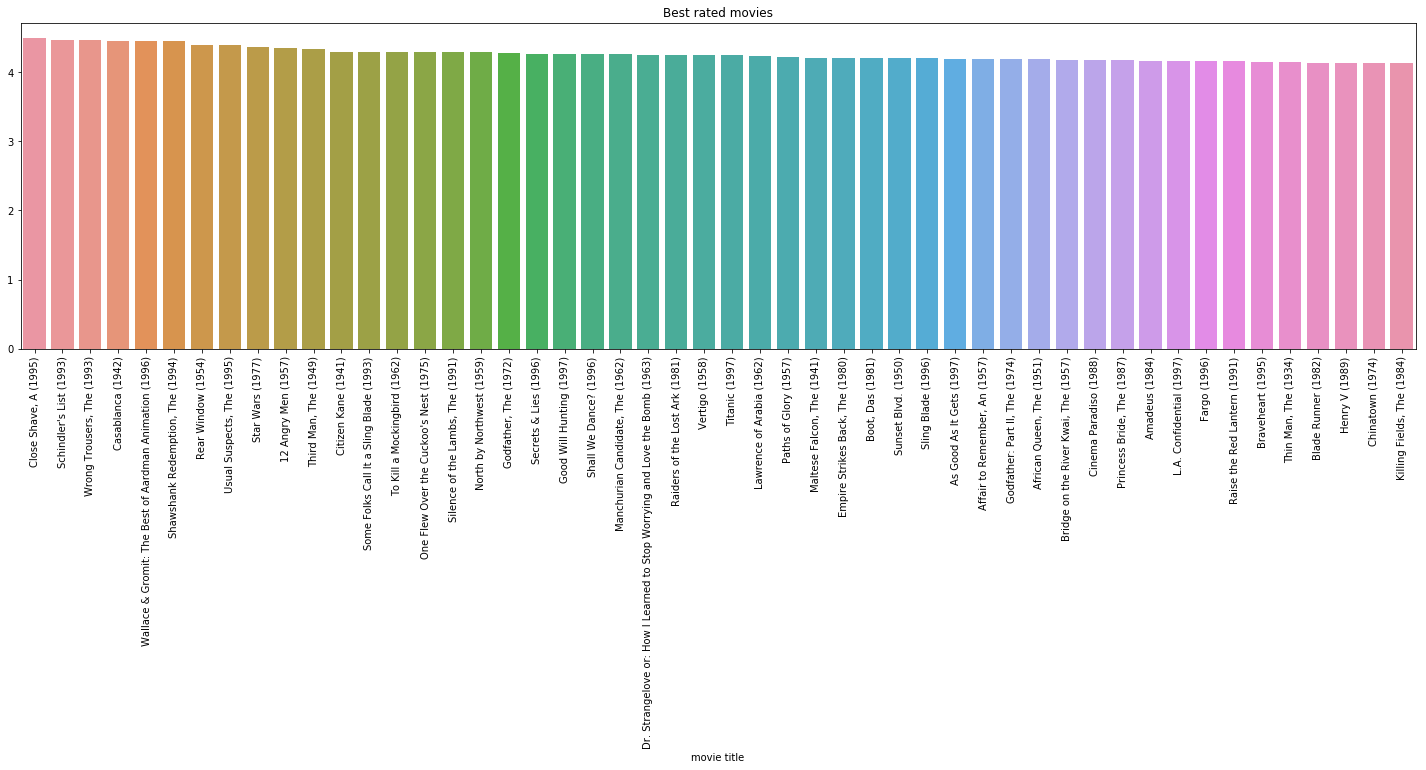

In [14]:
plt.figure(figsize=(25,6))
plt.title("Best rated movies")
sns.barplot(x=best_rated_movies.index[:50], y=best_rated_movies["mean"].values[:50])
plt.xticks(rotation=90)
plt.show()

### Least rated movie
Movie with at least 20 reviews are considered to avoid unknown movies.

In [15]:
least_rated_movies = mean_rating_movies[mean_rating_movies["size"]>20].sort_values("mean",ascending=False)

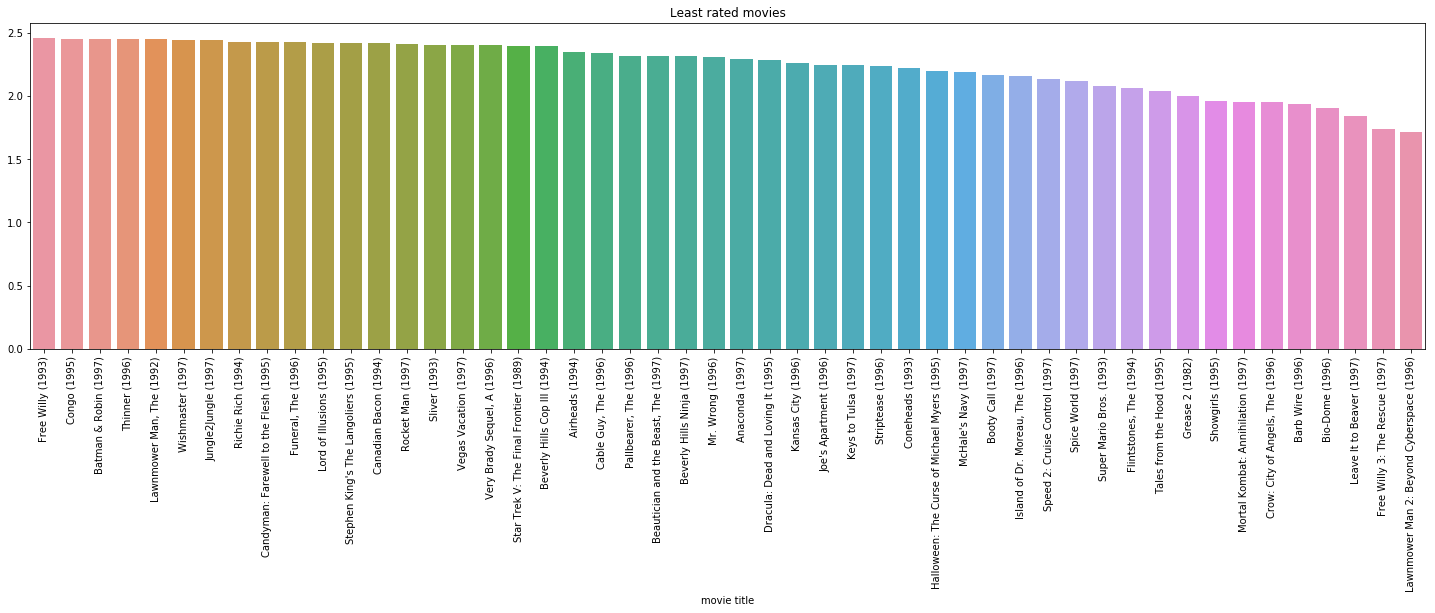

In [16]:
plt.figure(figsize=(25,6))
plt.title("Least rated movies")
sns.barplot(x=least_rated_movies.index[-50:], y=least_rated_movies["mean"].values[-50:])
plt.xticks(rotation=90)
plt.show()

### User with most ratings

In [17]:
most_rating_users = ratings_items.groupby("user_id").size().sort_values(ascending=False)

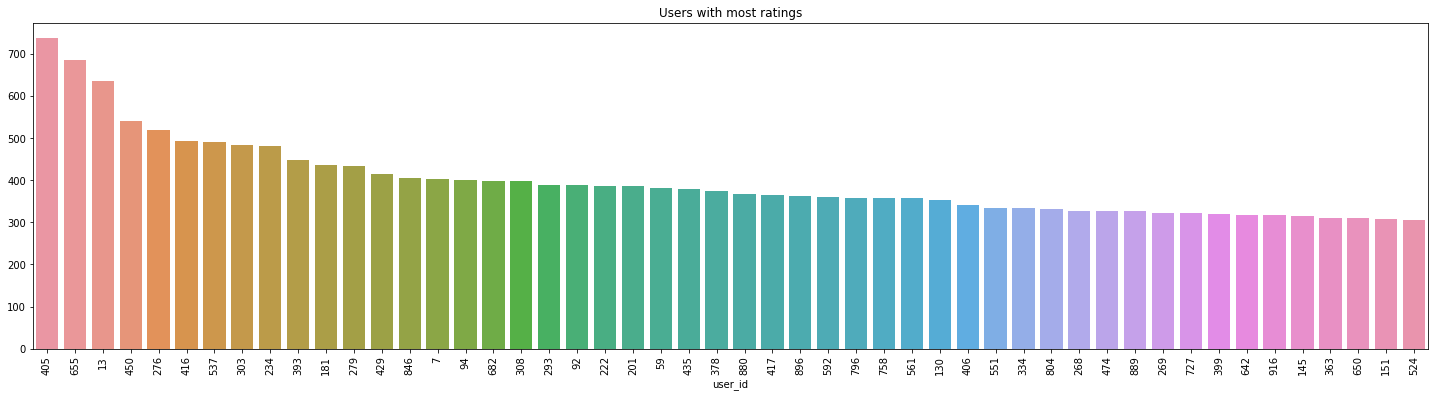

In [18]:
plt.figure(figsize=(25,6))
plt.title("Users with most ratings")
sns.barplot(x=most_rating_users[:50].index, y=most_rating_users[:50].values, order=most_rating_users[:50].index)
plt.xticks(rotation=90)
plt.show()

### Harshest reviewer

In [19]:
mean_rating_users = ratings_items.groupby("user_id")["rating"].agg(["mean","size"])#.sort_values()
worst_reviewers = mean_rating_users[mean_rating_users["size"]>20].sort_values("mean")

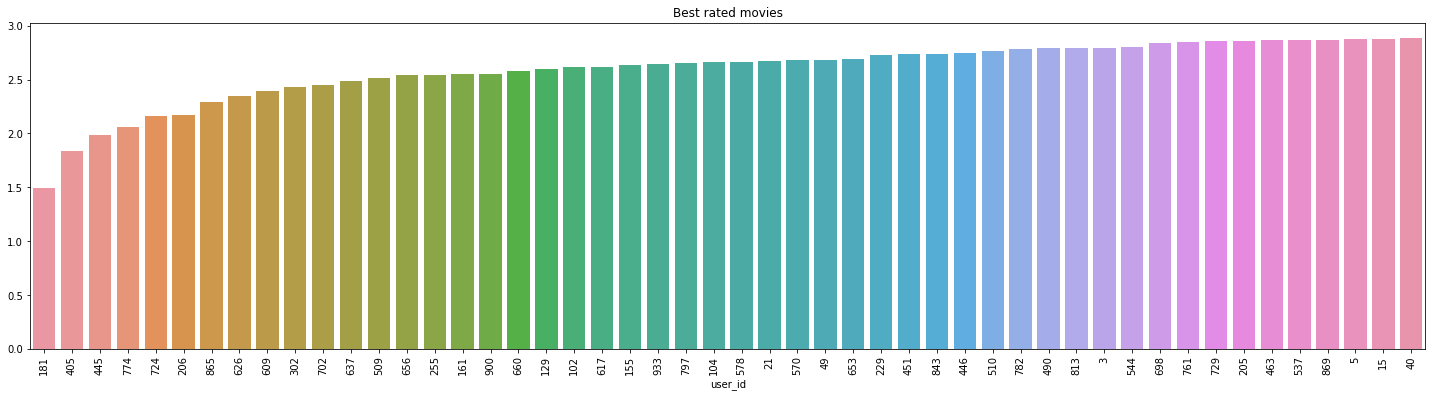

In [20]:
plt.figure(figsize=(25,6))
plt.title("Best rated movies")
sns.barplot(x=worst_reviewers.index[:50], y=worst_reviewers["mean"].values[:50], order=worst_reviewers.index[:50])
plt.xticks(rotation=90)
plt.show()

### Which movies are watching teenage girls?

In [21]:
import re
from collections import Counter
from wordcloud import WordCloud

def create_word_cloud(users_df, age_min=0, age_max=1000, sex="MF"):
    
    assert sex=="M" or sex=="F" or sex=="MF", "Specify sex of population : F, M or MF"
    if sex == "MF":
        sex_cond = ((users["sex"]=="M") | (users["sex"]=="F"))
    else:
        sex_cond = (users["sex"]==sex)
    people = users[(users["age"]<age_max) & (users["age"]>age_min) & sex_cond]

    assert len(people) > 1, "The selected population is empty."

    print("Number of selected reviewers :",len(people))
    
    
    people_ratings = pd.merge(ratings, people, how="inner")#[["user_id","rating","movie title"]]
    people_ratings = pd.merge(people_ratings, items, left_on="movie_id", right_on="movie id")
    people_ratings["movie title"] = people_ratings["movie title"].apply(lambda t: re.sub(" \(\d{4}\)","",t))
    
    s = 3000
    x, y = np.ogrid[:s, :s]
    mask = (x - s/2) ** 2 + (y - s/2) ** 2 > (0.45*s) ** 2
    mask = 255 * mask.astype(int)

    word_could_dict = Counter(people_ratings["movie title"].values)

    wordcloud = WordCloud(background_color="white",# mask=mask,
                          width = s, height = int(s/2)
                         ).generate_from_frequencies(word_could_dict)

    plt.figure(figsize=(20,5), dpi=500)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.savefig("wc.png")
    plt.show()
    
    return word_could_dict

Number of selected reviewers : 42


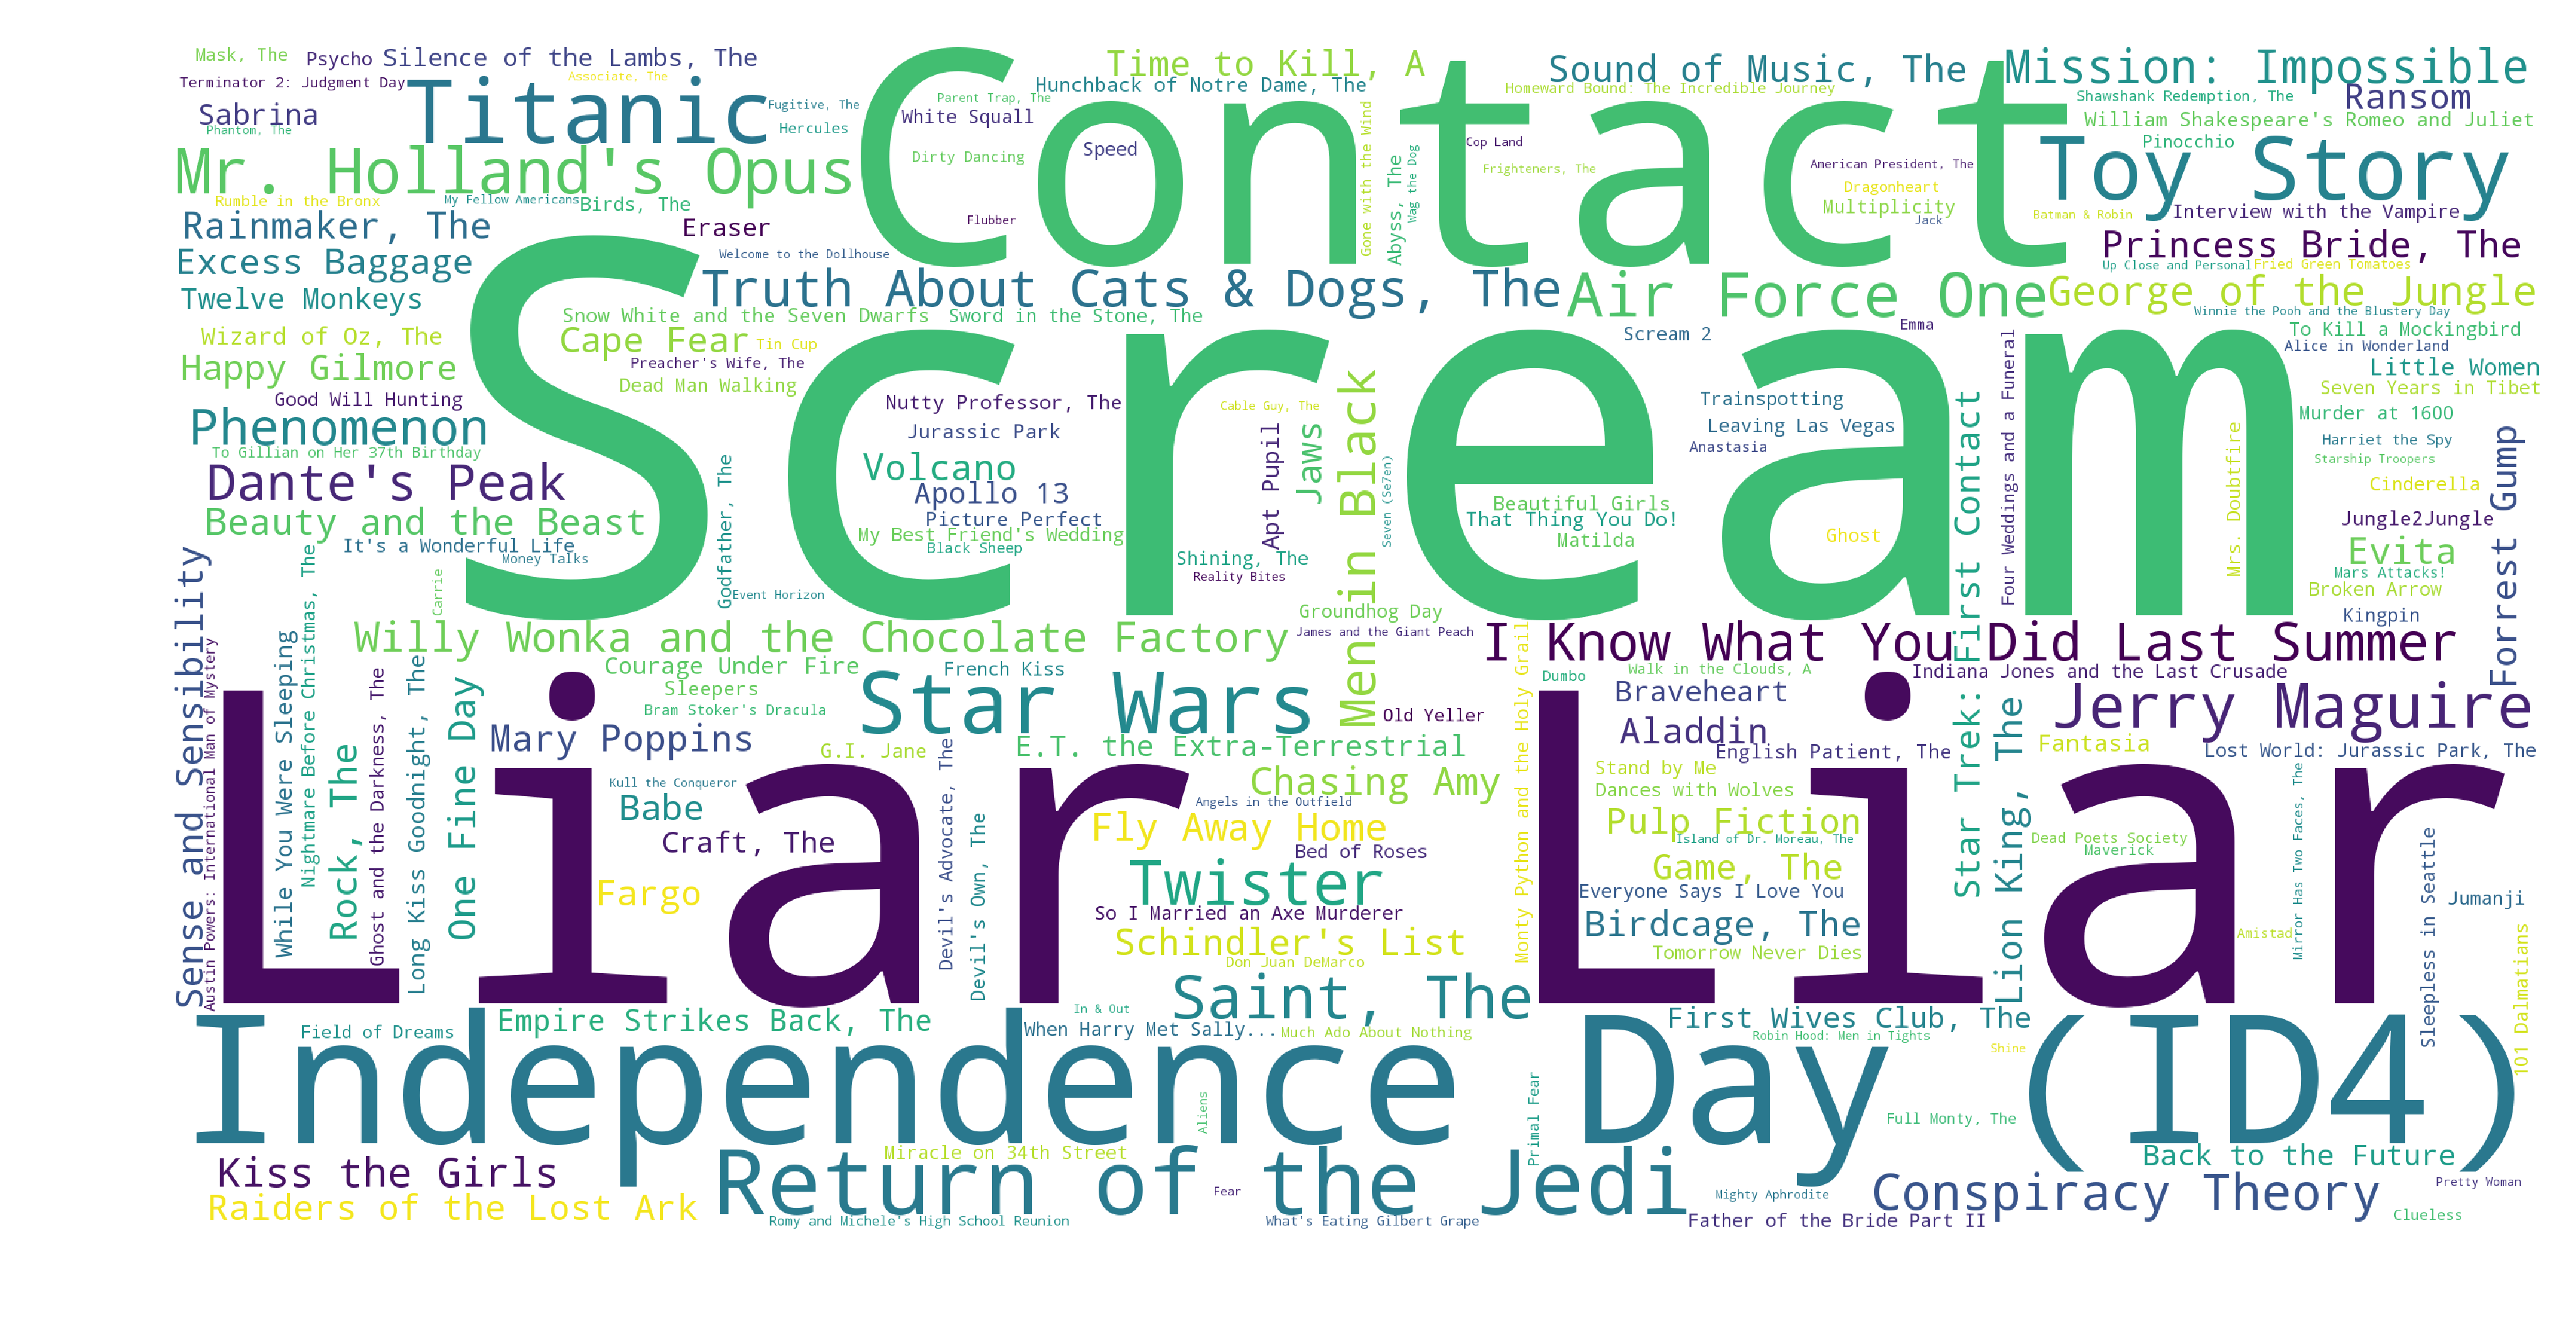

[('Scream', 38), ('Liar Liar', 28), ('Contact', 24), ('Independence Day (ID4)', 23), ('Return of the Jedi', 21), ('Titanic', 20), ('Toy Story', 20), ('Star Wars', 19), ("Mr. Holland's Opus", 19), ('Air Force One', 18)]


In [22]:
wcdict = create_word_cloud(users, age_max=21, sex="F")
print(wcdict.most_common(10))

Number of selected reviewers : 80


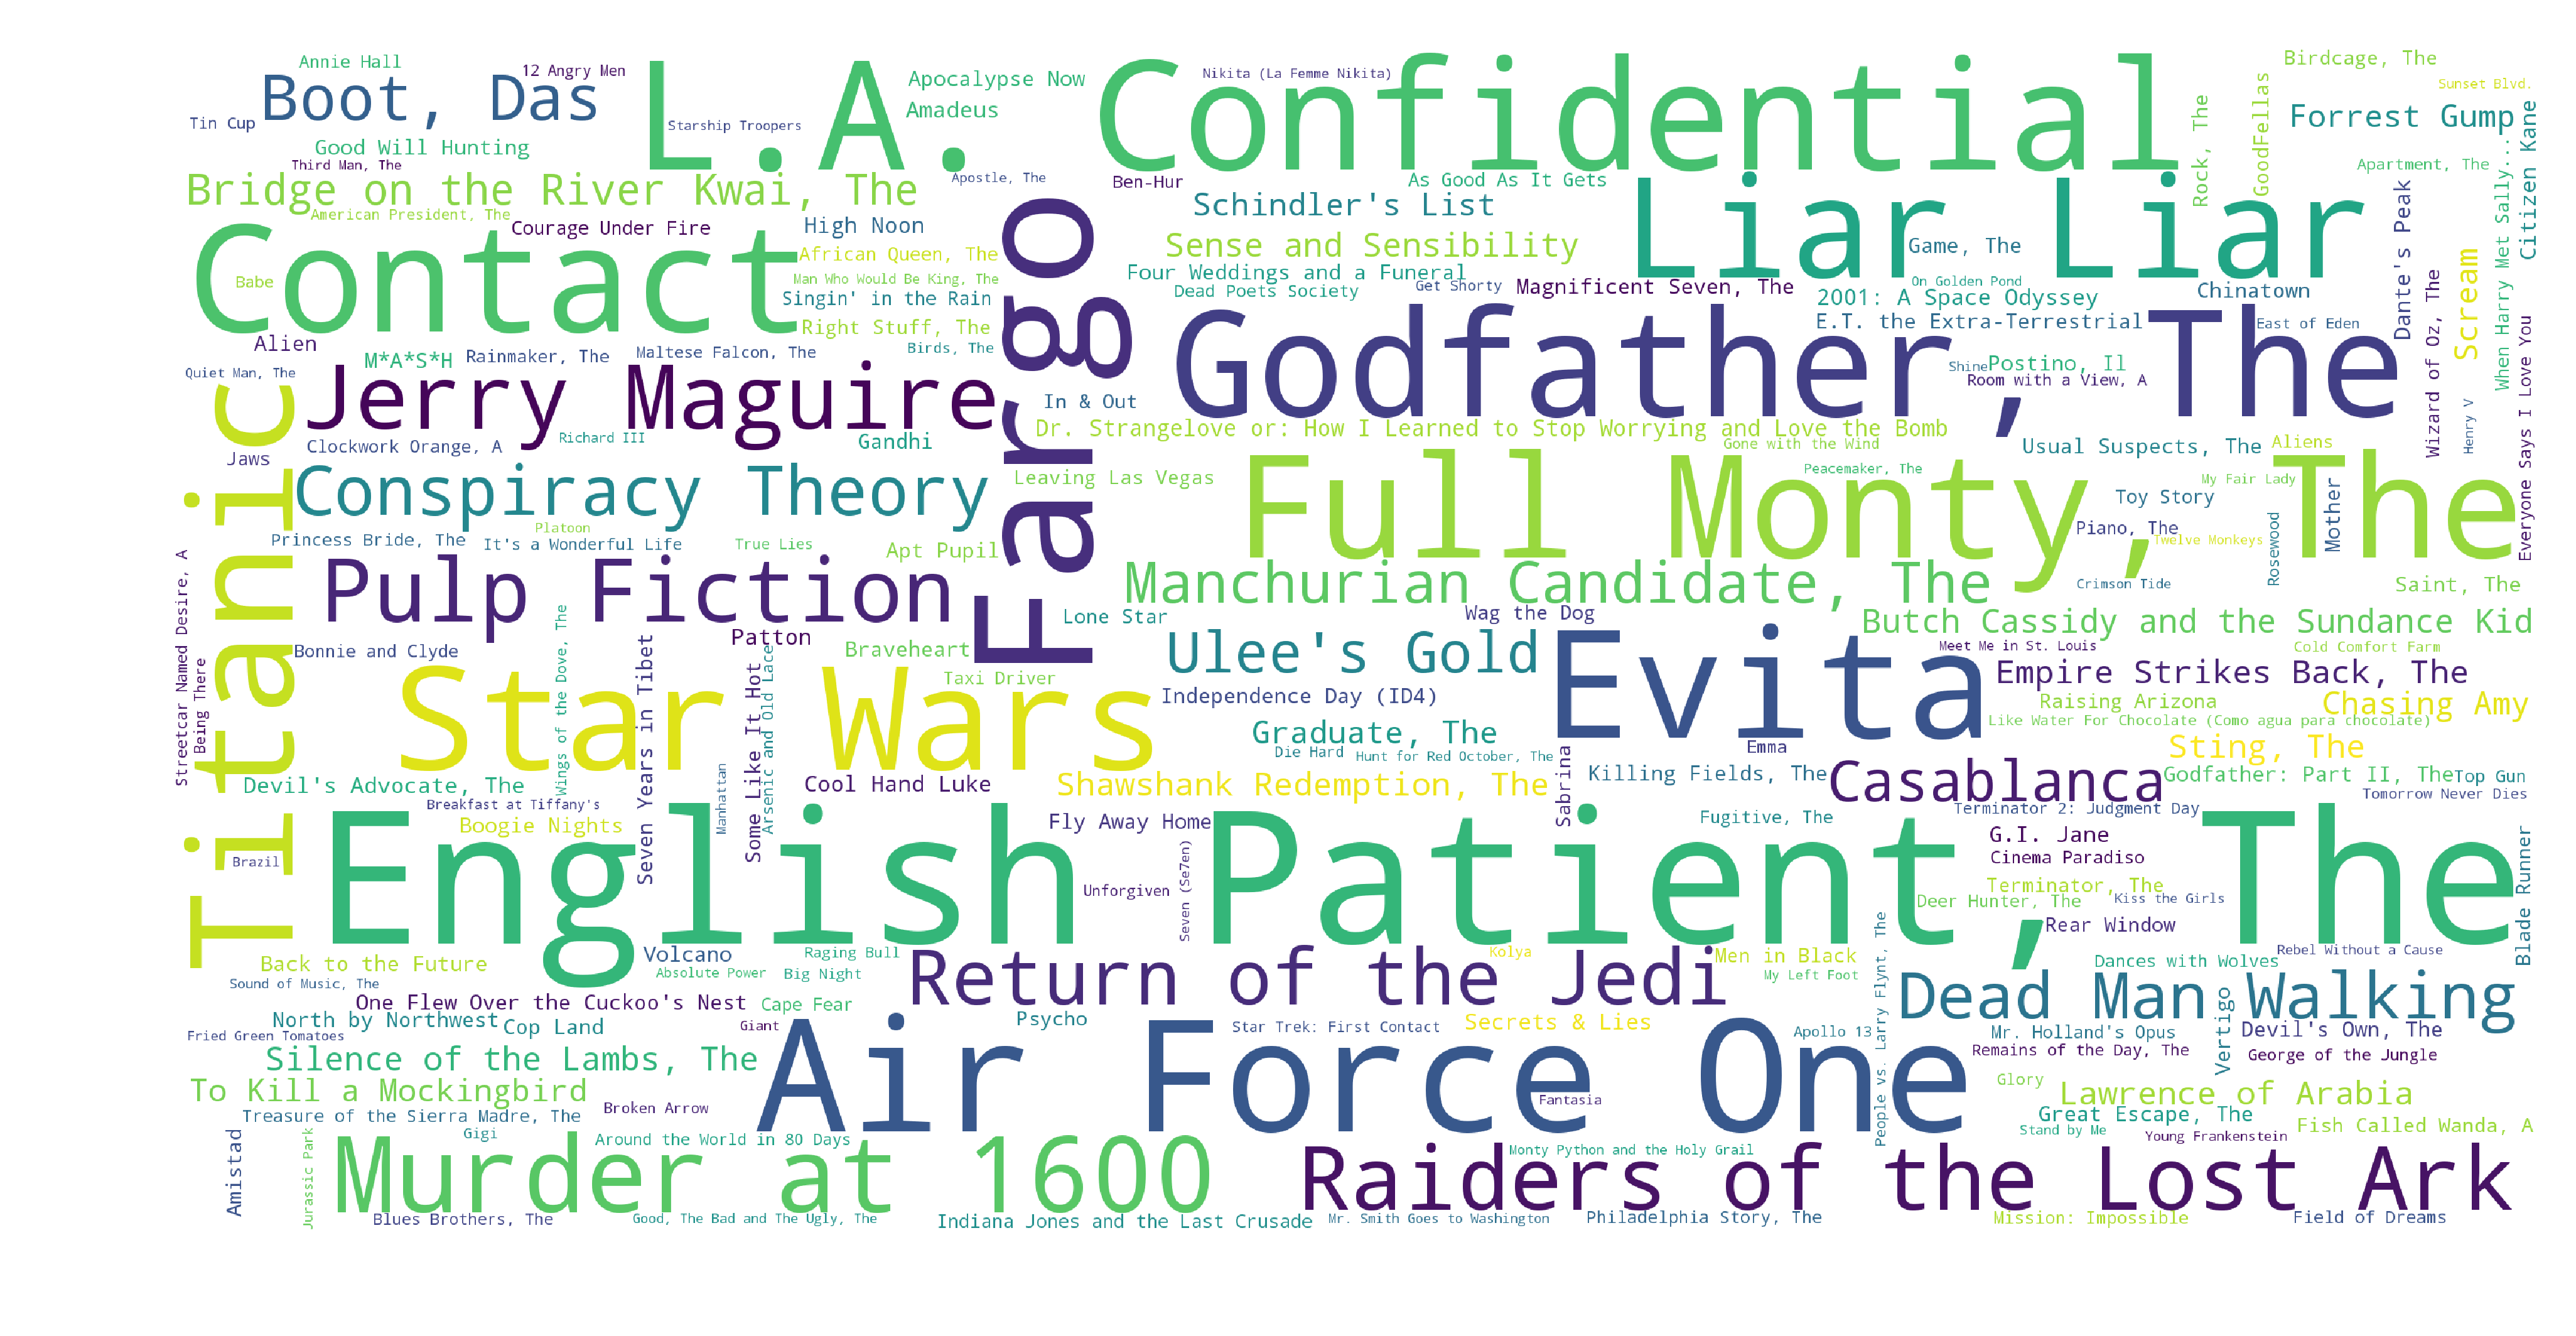

[('English Patient, The', 60), ('Fargo', 47), ('Air Force One', 42), ('L.A. Confidential', 40), ('Evita', 39), ('Contact', 38), ('Godfather, The', 37), ('Full Monty, The', 35), ('Titanic', 35), ('Star Wars', 35)]


In [23]:
wcdict = create_word_cloud(users, age_min=50, sex="M")
print(wcdict.most_common(10))

## Building the collaborative filtering model

Before going further, let's calculate the sparsity level of MovieLens dataset:

In [24]:
n_users = ratings.user_id.unique().shape[0]
n_items = ratings.movie_id.unique().shape[0]

In [25]:
sparsity = round(1.0-len(ratings)/float(n_users*n_items),3)
print('The sparsity level of MovieLens100K is ' +  str(sparsity*100) + '%')

The sparsity level of MovieLens100K is 93.7%


Now, we will create a user-item matrix which can be used to calculate the similarity between users and items.  
Actually there will be two user-item matrices, one for training and another for testing.

Let's create two user-item matrices, one for training and another for testing

In [26]:
from sklearn.model_selection import train_test_split
ratings_train, ratings_test = train_test_split(ratings, test_size=0.25)

In [27]:
train_data_matrix = np.zeros((n_users, n_items))
for line in ratings_train.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]

test_data_matrix = np.zeros((n_users, n_items))
for line in ratings_test.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

Now, we will calculate the similarity. We can use the pairwise_distance function from sklearn to calculate the cosine similarity.

In [28]:
from sklearn.metrics.pairwise import pairwise_distances 
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

Let's visualize the similarity between users and items.

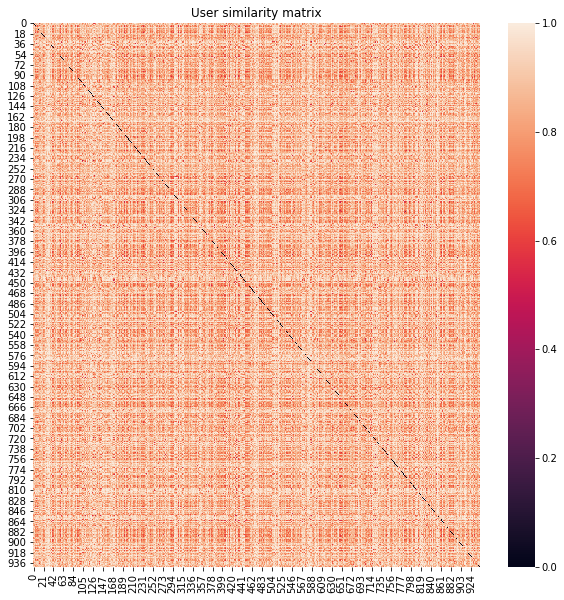

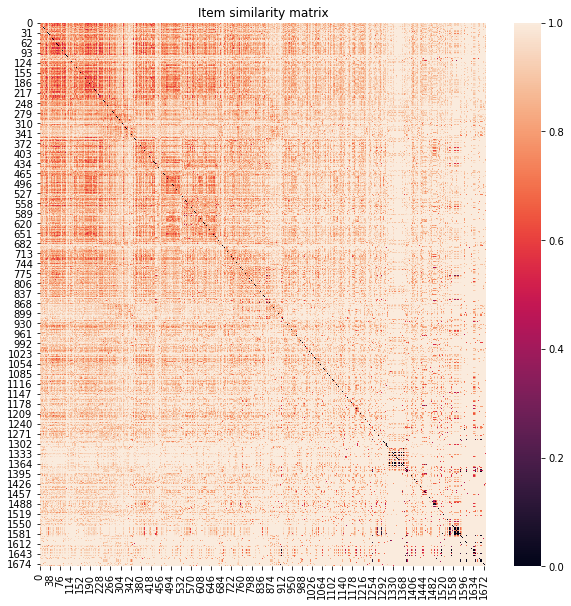

In [29]:
plt.figure(figsize=(10,10))
plt.title("User similarity matrix")
sns.heatmap(user_similarity)
plt.show()

plt.figure(figsize=(10,10))
plt.title("Item similarity matrix")
sns.heatmap(item_similarity)
plt.show()


 The next step is to make predictions based on these similarities. Let’s define a function to do just that.

In [30]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred


In [31]:
user_prediction = predict(train_data_matrix, user_similarity, type='user')
item_prediction = predict(train_data_matrix, item_similarity, type='item')

### Evaluation

In [32]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [33]:
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 3.1215453308636807
Item-based CF RMSE: 3.4472595250090596


Let's have a look at the predictions (sorted from highest to lowest rating) for a user selected randomly. Seems that he will ennjoy Star Wars and Fargo the most. Not so surprising since these are very popular movies!

In [34]:
r = pd.Series(user_prediction[150,:], items["movie title"], name="rating")
r.sort_values(ascending=False)[:20]

movie title
Star Wars (1977)                    2.288010
Contact (1997)                      1.941238
Fargo (1996)                        1.938930
Return of the Jedi (1983)           1.844772
English Patient, The (1996)         1.820638
Godfather, The (1972)               1.773593
Scream (1996)                       1.696126
Toy Story (1995)                    1.694044
Air Force One (1997)                1.671795
Raiders of the Lost Ark (1981)      1.652107
Liar Liar (1997)                    1.632365
Titanic (1997)                      1.605476
Silence of the Lambs, The (1991)    1.575723
Pulp Fiction (1994)                 1.564531
Independence Day (ID4) (1996)       1.551493
Rock, The (1996)                    1.514816
Twelve Monkeys (1995)               1.506508
Empire Strikes Back, The (1980)     1.444872
Jerry Maguire (1996)                1.425264
Full Monty, The (1997)              1.362293
Name: rating, dtype: float64

## Introduction to matrix factorization

Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF.  
The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items.  
When you have a very sparse matrix, with a lot of dimensions, by doing matrix factorization you can restructure the user-item matrix into low-rank structure, and you can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector.  
You fit this matrix to approximate your original matrix, as closely as possible, by multiplying the low-rank matrices together, which fills in the entries missing in the original matrix.

### SVD
A common approach for matrix factorization is SVD (Singular Value Decomposition).

In [35]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

def get_predicted_ratings_svd(n_latent_factors=20):
    #get SVD components from train matrix. Choose k.
    u, s, vt = svds(train_data_matrix, k = n_latent_factors)
    s_diag_matrix=np.diag(s)
    X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
    return X_pred

In [36]:
print('User-based CF RMSE: ' + str(rmse(get_predicted_ratings_svd(), test_data_matrix)))

User-based CF RMSE: 2.712117127567462


Let's run the matrix factorization for different values of $k$ (number of latent factors) to find the optimum value.

In [37]:
ks = range(2,40)
rmses = []
for k in ks:
    X_pred = get_predicted_ratings_svd(n_latent_factors=k)
    rmses.append(rmse(X_pred, test_data_matrix))

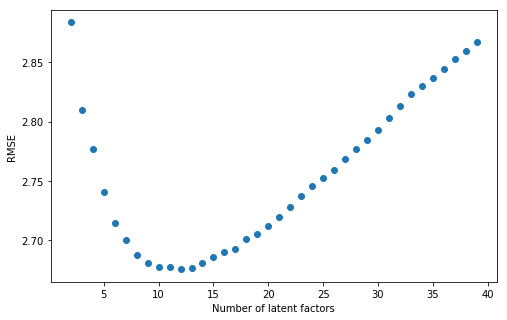

In [38]:
plt.figure(figsize=(8,5))
plt.plot(ks, rmses, "o")
plt.xlabel("Number of latent factors")
plt.ylabel("RMSE")
plt.show()

Recommandations for user #886. Need to understand these funny predicted ratings.

In [39]:
u, s, vt = svds(train_data_matrix, k = 10)
s_diag_matrix=np.diag(s)

In [40]:
r = np.dot(np.dot(u[886,:], s_diag_matrix), vt)

In [41]:
pd.concat([pd.Series(r, name="recommendation score"), 
           items[["movie id","movie title"]]], axis=1).sort_values(by="recommendation score", ascending=False)

recommendation score  movie id  \
0                4.982213         1   
120              4.138628       121   
49               4.126172        50   
150              4.069946       151   
172              3.398123       173   
404              3.300154       405   
116              3.178274       117   
431              3.169981       432   
98               3.100828        99   
14               3.095354        15   
180              3.092496       181   
70               2.974375        71   
221              2.968673       222   
124              2.964596       125   
167              2.953033       168   
117              2.933740       118   
287              2.916941       288   
587              2.863447       588   
94               2.817210        95   
293              2.787691       294   
418              2.761982       419   
131              2.712146       132   
256              2.701124       257   
24               2.618700        25   
6                2.613335         7   
741              2.549648       742   
142              2.536042       143   
495              2.500138       496   
236              2.449293       237   
27               2.256263        28   
..                    ...       ...   
689             -0.530090       690   
191             -0.531283       192   
284             -0.539502       285   
211             -0.540155       212   
895             -0.541125       896   
955             -0.544712       956   
189             -0.550790       190   
326             -0.554318       327   
75              -0.559275        76   
59              -0.560235        60   
197             -0.562394       198   
527             -0.564110       528   
683             -0.574920       684   
136             -0.584511       137   
44              -0.612901        45   
51              -0.615242        52   
13              -0.620147        14   
268             -0.702481       269   
241             -0.707969       242   
749             -0.718600       750   
517             -0.747244       518   
58              -0.756810        59   
310             -0.758616       311   
11              -0.803216        12   
181             -0.827656       182   
285             -0.882720       286   
169             -0.998538       170   
305             -1.049194       306   
302             -1.113436       303   
301             -1.348300       302   

                                      movie title  
0                                Toy Story (1995)  
120                 Independence Day (ID4) (1996)  
49                               Star Wars (1977)  
150  Willy Wonka and the Chocolate Factory (1971)  
172                    Princess Bride, The (1987)  
404                    Mission: Impossible (1996)  
116                              Rock, The (1996)  
431                               Fantasia (1940)  
98         Snow White and the Seven Dwarfs (1937)  
14                      Mr. Holland's Opus (1995)  
180                     Return of the Jedi (1983)  
70                          Lion King, The (1994)  
221               Star Trek: First Contact (1996)  
124                             Phenomenon (1996)  
167        Monty Python and the Holy Grail (1974)  
117                                Twister (1996)  
287                                 Scream (1996)  
587                   Beauty and the Beast (1991)  
94                                 Aladdin (1992)  
293                              Liar Liar (1997)  
418                           Mary Poppins (1964)  
131                      Wizard of Oz, The (1939)  
256                           Men in Black (1997)  
24                           Birdcage, The (1996)  
6                           Twelve Monkeys (1995)  
741                                 Ransom (1996)  
142                    Sound of Music, The (1965)  
495                  It's a Wonderful Life (1946)  
236                          Jerry Maguire (1996)  
27                        